In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
import random

In [2]:
fmnist = datasets.FashionMNIST(root="./data", download=True, train=True)

In [3]:
# Training data
tr_images = fmnist.data
tr_targets = fmnist.targets

In [4]:
tr_images.shape, tr_targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
val_fmnist = datasets.FashionMNIST(root="./data", download=True, train=False)

In [6]:
# Validation data
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [7]:
val_images.shape, val_targets.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:
class FMNISTDataset(Dataset):
    """Class which fetches the dataset"""
    def __init__(self, S, y):
        S = S.float()/255 # Converting the input into floating point numbers and scaling the input to (0, 1)
        S = S.unsqueeze(1) # This converts the shape from [batch_size, 28, 28] to [batch_size, 1, 28, 28]
        self.S, self.y = S, y
    def __getitem__(self, iS):
        """ This method contains logic for what should be returned 
            when we ask for iS th datapoint
        """
        S, y = self.S[iS], self.y[iS]
        return S.to(device), y.to(device)
    def __len__(self):
        """ This method computes the number of datapoints in the dataset
        """
        return len(self.S)

In [10]:
def get_model():
    """ This function creates a convolutional neural net (with two convolutional layers, two maxpool layers, 
        and three dense layers), the loss function(cross entropy) and the optmizer(Adam)"""
    SNet = nn.Sequential(
        nn.Conv2d(1, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(16 * 4 * 4, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(SNet.parameters(), lr=1e-2)
    return SNet, loss_fn, optimizer

In [11]:
def train_batch(S, y, SNet, optimizer, loss_fn):
    """This function will train the neural net on a 
       batch of images"""
    SNet.train() # Tells the neural net that you are training it
    prediction = SNet(S) 
    batch_loss = loss_fn(prediction, y) # Computing the loss value
    batch_loss.backward()  # Computing the gradients of the loss fn wrt the parameters of the neural net
    optimizer.step() # Updating the values of the parameters of the neural net 
    optimizer.zero_grad() # Flush gradients memory for next batch of calculations
    return batch_loss.item()

In [12]:
def accuracy(S, y, SNet):
    """This function calculates whether the model's predictions for each input in the batch are correct, 
       comparing the predicted class (from the argmax of the output logits) with the true class labels.
       It then returns a list of booleans, where each element is True if the corresponding prediction 
       was correct and False if it was incorrect."""
    SNet.eval()
    with torch.no_grad():
        prediction = SNet(S)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [13]:
def get_data():
    """This function prepares and returns two data loaders: one for training (with batching and shuffling) 
       and one for validation (with the full validation set)"""
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [14]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [15]:
print(SNet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [16]:
@torch.no_grad()
def val_loss(S, y, SNet):
    """This function computes the validation loss of the neural net"""
    prediction = SNet(S)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [17]:
# Training the neural net
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], [] # Initializing the lists which will contain training accuracy, training loss, validation accuracy, 
# validation loss at every epoch
for epoch in range(5):  # Training the neural net for 5 epochs
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], [] # Initializing the lists that will contain the accuracy and loss value at every batch
    for iS, batch in enumerate(iter(trn_dl)): # Creating batches of training data by iterating through the dataloader
        S, y = batch
        batch_loss = train_batch(S, y, SNet, optimizer, loss_fn) # train the batch with the aid of the train_batch function and compute the loss
        train_epoch_losses.append(batch_loss) # Storing the training batch loss to the train_epoch_losses list
    train_epoch_loss = np.array(train_epoch_losses).mean() # Computing the training loss for the epoch
    for iS, batch in enumerate(iter(trn_dl)):
        S, y = batch
        is_correct = accuracy(S, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies) # Computing the training accuracy for the epoch
    for iS, batch in enumerate(iter(val_dl)):
        S, y = batch
        val_is_correct = accuracy(S, y, SNet)
        validation_loss = val_loss(S, y, SNet)
    val_epoch_accuracy = np.mean(val_is_correct) # Computing the validation accuacy for the epoch
    # Storing the training and validation loss values and accuracy in the respective lists
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


In [20]:
train_losses, train_accuracies, val_losses, val_accuracies

([0.5453124990860622,
  0.43666527645985287,
  0.4165937164068222,
  0.4003715436736743,
  0.3982072040041288],
 [0.8464, 0.8495666666666667, 0.8562, 0.8626666666666667, 0.8417],
 [0.45120352506637573,
  0.4434438943862915,
  0.42959028482437134,
  0.4318244755268097,
  0.4653491675853729],
 [0.8359, 0.8374, 0.8435, 0.8475, 0.8354])

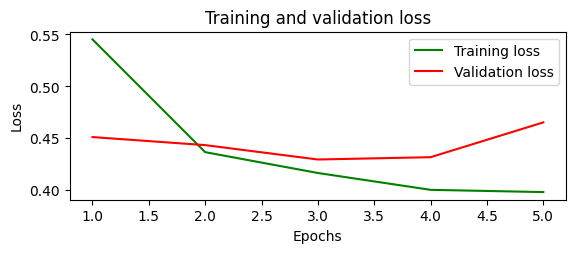

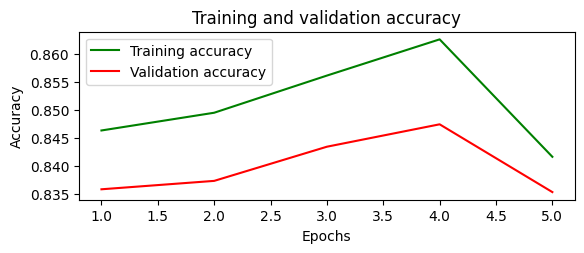

In [25]:
# Plotting the training loss, training accuracy, validation loss, validation accuracy
epochs = np.arange(5) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()